In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from util import stopwatch, get_stopwatch
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_img_row_size = 8
def save_labels(labels, path):
    with open(path, 'w') as f:
        for i, label in enumerate(labels.detach().numpy()):
            l = np.where(label==1)[0][0]
            print(l, file=f, end=('\n' if (i+1) % save_img_row_size == 0 else ' '))
torch.manual_seed(7)

In [112]:
num_epochs = 200
batch_size = 100
sample_dir = 'samples_dc_cond'

if not os.path.exists(sample_dir): os.makedirs(sample_dir)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])

def one_hot(x):
    r = torch.zeros(num_labels)
    r[x.item()] = 1
    return r
mnist = torchvision.datasets.MNIST(root='~/mnist-data/', train=True, download=True,
                                   transform=transform, target_transform=one_hot)

data_loader = torch.utils.data.DataLoader(dataset=mnist, batch_size = batch_size, shuffle=True)

60000 images of torch.Size([1, 28, 28])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


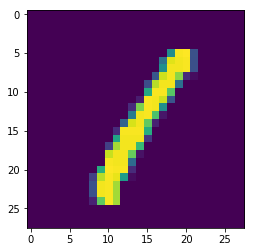

In [113]:
from matplotlib import pyplot as plt
print("{} images of {}".format(len(mnist), mnist[1][0].shape))
print(mnist[3][1])
plt.imshow(mnist[3][0][0])

In [114]:
latent_size = 64
image_size = 28 * 28
num_labels = 10
num_colors = 1
num_kernels = 32

D = nn.Sequential(
    # add label to each pixel in input. 13x28x28
    nn.Conv2d(num_labels+num_colors, num_kernels, 4, 2, 1),
    # 32x14x14
    nn.LeakyReLU(0.2),
    nn.Conv2d(num_kernels, num_kernels*2, 4, 2, 1),
    # 64x7x7
    nn.BatchNorm2d(num_kernels * 2),
    nn.LeakyReLU(0.2),
    nn.Conv2d(num_kernels*2, num_kernels*4, 3, 2),
    # 128x3x3
    nn.BatchNorm2d(num_kernels * 4),
    nn.LeakyReLU(0.2),
    nn.Conv2d(num_kernels*4, 1, 3),
    nn.Sigmoid())
D = D.to(device)
D_losses = []

G = nn.Sequential(
    nn.ConvTranspose2d(latent_size+num_labels, num_kernels*8, 4, 1, 0),
    # 256x4x4
    nn.BatchNorm2d(num_kernels*8),
    nn.ReLU(),
    nn.ConvTranspose2d(num_kernels*8, num_kernels*4, 3, 2, 1),
    # 128x7x7
    nn.BatchNorm2d(num_kernels*4),
    nn.ReLU(),
    nn.ConvTranspose2d(num_kernels*4, num_kernels*2, 4, 2, 1),
    # 64x14x14
    nn.BatchNorm2d(num_kernels*2),
    nn.ReLU(),
    nn.ConvTranspose2d(num_kernels*2, num_colors, 4, 2, 1),
    # 1x28x28
    nn.Tanh())
G = G.to(device)
G_losses = []

In [115]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [116]:
def denorm(x): return ((x+1)/2).clamp(0,1)
def reset_grad(): d_optimizer.zero_grad(); g_optimizer.zero_grad()

In [117]:
# Say a minibatch has images of numbers 3, 5, 9, 2, and 6.
# Then the discriminator will be fed real images of 3, 5, 9, 2, and 6.
# Then the generator is fed 3+noise, 5+noise, 9+noise, 2+noise, 6+noise and produces 5 fake images.
# The discriminator is fed the 5 fake images assigne dthe same labels.
total_step = len(data_loader)
for epoch in range(num_epochs):
    stopwatch()
    D_loss_this_epoch = []
    G_loss_this_epoch = []
    D_losses.append(D_loss_this_epoch)
    G_losses.append(G_loss_this_epoch)
    
    for i, (images, labels_cpu) in enumerate(data_loader):
        real_labels = torch.ones (batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        labels = labels_cpu.to(device)
        
        ## discriminator
        # input real images to discriminator
        images = images.to(device)
        # expand batch_size * 10 to batch_size * 10 * image_width * image_height
        labels_dups = labels.unsqueeze(dim=-1).unsqueeze(dim=-1).expand(labels.shape+images.shape[2:])
        d_inputs = torch.cat((images, labels_dups), 1)
        
        # compute loss on real images
        outputs = D(d_inputs)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # generate fake images
        z = torch.randn(batch_size, latent_size).to(device)
        g_inputs = torch.cat((z, labels), 1) # batch_size * latent_dim
        g_inputs = g_inputs.unsqueeze(-1).unsqueeze(-1) # -> batch_size * latent_dim * 1 * 1 for DC generator
        fake_images = G(g_inputs)
        
        # input fake images to discriminator
        d_inputs = torch.cat((fake_images, labels_dups), 1)
        outputs = D(d_inputs)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # compute total loss and backprop
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        ## generator
        # generate fake images
        z = torch.randn(batch_size, latent_size).to(device)
        g_inputs = torch.cat((z, labels), 1).unsqueeze(-1).unsqueeze(-1)
        fake_images = G(g_inputs)
        
        # feed to discriminator
        d_inputs = torch.cat((fake_images, labels_dups), 1)
        outputs = D(d_inputs)
        
        # compute loss for generator and backprop
        g_loss = criterion(outputs, real_labels)
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 20 == 0:
            # only gets a subsample of the losses but that's okay
            D_loss_this_epoch.append(d_loss.item())
            G_loss_this_epoch.append(g_loss.item())
            t = get_stopwatch()
            print('Epoch [{}/{}], [{}/{}] ({:.1f}s/{:.1f}s) dl({:.4f}) gl({:.4f}), D(x)={:.2f}, D(G(z))={:.2f}'
                  .format(epoch, num_epochs, i+1, total_step,
                          t, t*total_step/i,
                          d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()), end="\r")
    print("")
    if epoch == 0:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_labels(labels_cpu, os.path.join(sample_dir, 'fake_labels-{}.txt'.format(epoch+1)))
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

torch.save(G.state_dict(), 'G_cond.ckpt')
torch.save(D.state_dict(), 'D_cond.ckpt')

Epoch [0/200], [600/600] (31.3s/31.3s) dl(0.1764) gl(3.7357), D(x)=0.95, D(G(z))=0.10
Epoch [1/200], [600/600] (31.1s/31.2s) dl(0.0749) gl(6.5149), D(x)=0.95, D(G(z))=0.01
Epoch [2/200], [600/600] (31.4s/31.5s) dl(0.1824) gl(4.3438), D(x)=0.99, D(G(z))=0.13
Epoch [3/200], [600/600] (31.3s/31.4s) dl(0.1783) gl(3.7198), D(x)=0.96, D(G(z))=0.08
Epoch [4/200], [600/600] (31.3s/31.4s) dl(0.4351) gl(2.2446), D(x)=0.84, D(G(z))=0.17
Epoch [5/200], [600/600] (31.2s/31.2s) dl(0.3533) gl(3.4029), D(x)=0.82, D(G(z))=0.05
Epoch [6/200], [600/600] (31.1s/31.2s) dl(0.5758) gl(2.3636), D(x)=0.70, D(G(z))=0.09
Epoch [7/200], [600/600] (31.2s/31.3s) dl(0.7886) gl(1.8402), D(x)=0.79, D(G(z))=0.33
Epoch [8/200], [600/600] (31.2s/31.2s) dl(0.7244) gl(1.2882), D(x)=0.85, D(G(z))=0.38
Epoch [9/200], [600/600] (31.2s/31.3s) dl(1.1880) gl(1.2159), D(x)=0.57, D(G(z))=0.34
Epoch [10/200], [600/600] (31.1s/31.2s) dl(1.1876) gl(1.8604), D(x)=0.54, D(G(z))=0.28
Epoch [11/200], [600/600] (31.1s/31.2s) dl(1.1591) gl

Epoch [94/200], [600/600] (31.6s/31.6s) dl(0.9930) gl(1.9625), D(x)=0.57, D(G(z))=0.28
Epoch [95/200], [600/600] (31.4s/31.5s) dl(1.3409) gl(0.7216), D(x)=0.74, D(G(z))=0.58
Epoch [96/200], [600/600] (31.2s/31.2s) dl(0.7060) gl(1.8605), D(x)=0.80, D(G(z))=0.34
Epoch [97/200], [600/600] (31.3s/31.3s) dl(1.0782) gl(1.0185), D(x)=0.53, D(G(z))=0.28
Epoch [98/200], [600/600] (31.2s/31.2s) dl(0.7927) gl(1.1084), D(x)=0.80, D(G(z))=0.39
Epoch [99/200], [600/600] (31.1s/31.2s) dl(0.7269) gl(1.5445), D(x)=0.76, D(G(z))=0.33
Epoch [100/200], [600/600] (31.1s/31.2s) dl(1.3062) gl(0.8870), D(x)=0.61, D(G(z))=0.48
Epoch [101/200], [600/600] (31.2s/31.2s) dl(0.7069) gl(1.0052), D(x)=0.82, D(G(z))=0.36
Epoch [102/200], [600/600] (31.1s/31.2s) dl(0.7302) gl(1.2203), D(x)=0.62, D(G(z))=0.18
Epoch [103/200], [600/600] (31.3s/31.4s) dl(1.0822) gl(1.0917), D(x)=0.51, D(G(z))=0.26
Epoch [104/200], [600/600] (31.3s/31.3s) dl(0.8648) gl(1.3904), D(x)=0.83, D(G(z))=0.44
Epoch [105/200], [600/600] (31.2s/31.2

KeyboardInterrupt: 